In [34]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

In [35]:
# Cargar el modelo guardado
model_filename = 'logistic_model.pkl'
loaded_model = joblib.load(model_filename)

In [36]:
# Cargar el StandardScaler guardado
scaler_filename = 'scaler_model.pkl'
scaler = joblib.load(scaler_filename)

In [37]:
df_row_1 = pd.read_parquet("tres_meses_modelo.parquet")
filtered_df = df_row_1[df_row_1['flag'] == 1]
df_row_1 = filtered_df.sample(n=1, random_state=40)
 
df_row_1

descripcion,DayHourMinute,% BOMBA ALIM P45 M2 GLUCOSA,% BOMBA ALIMENT COLUMNAS 353509,% BOMBA ALIMENTACION CUBA M7,% BOMBA ALIMENTACION P45 M2 H0,% VF BOMBA ALIMENTACION W7,BOMBA RECUPERACIÓN GRUPOS H0,BRIX PUNTO CARGA Nº1 GLUCOSA,BRIX PUNTO CARGA Nº2 GLUCOSA,CAUDAL BOMBA TITANIC FECULERIA,...,VLV REG NIVEL FLASH SDA D.C.,VLV REGUL NIVEL CUBA MEZCLA DC,VOL RECUP ANION GRUPOS GLUC,VOL RECUP CATION GRUPOS H0,VOL. RECUP. ANIÓN GRUPO 4,VOL. RECUP. CATIÓN GRUPO 4,VOLUMEN CIP A EDAR,W10 STATUS,W7 STATUS,flag
4692,2020-02-05 21:00:00,NaN,NaN,NaN,6444.795898,73.862274,NaN,NaN,NaN,57.773438,...,26.503563,51.012421,NaN,NaN,NaN,NaN,NaN,256.0,NaN,1


In [38]:
col_drop = ['COT AGUAS ÁCIDAS NUEVO', 'COT AGUAS ÁCIDAS', 'COR TITÁNIC AZÚCARES', 'COT TITÁNIC AZÚCARES NUEVO', 'DayHourMinute']
df_row_1= df_row_1.drop(columns=[col for col in col_drop if col in df_row_1.columns])

In [39]:
df_row_1 = df_row_1.fillna(0)
df_row_1

descripcion,% BOMBA ALIM P45 M2 GLUCOSA,% BOMBA ALIMENT COLUMNAS 353509,% BOMBA ALIMENTACION CUBA M7,% BOMBA ALIMENTACION P45 M2 H0,% VF BOMBA ALIMENTACION W7,BOMBA RECUPERACIÓN GRUPOS H0,BRIX PUNTO CARGA Nº1 GLUCOSA,BRIX PUNTO CARGA Nº2 GLUCOSA,CAUDAL BOMBA TITANIC FECULERIA,CAUDAL SDA BOMBA BALSA RT,...,VLV REG NIVEL FLASH SDA D.C.,VLV REGUL NIVEL CUBA MEZCLA DC,VOL RECUP ANION GRUPOS GLUC,VOL RECUP CATION GRUPOS H0,VOL. RECUP. ANIÓN GRUPO 4,VOL. RECUP. CATIÓN GRUPO 4,VOLUMEN CIP A EDAR,W10 STATUS,W7 STATUS,flag
4692,0.0,0.0,0.0,6444.795898,73.862274,0.0,0.0,0.0,57.773438,26.983553,...,26.503563,51.012421,0.0,0.0,0.0,0.0,0.0,256.0,0.0,1


In [40]:
X = df_row_1.drop(columns=['flag'])

In [41]:
X_scaled = scaler.transform(X)
 
probability = loaded_model.predict_proba(X_scaled)[:, 1][0]
 
print("Probability that flag is 1:", probability)

Probability that flag is 1: 0.5727476993448888


In [42]:
coefficients = loaded_model.coef_[0]
feature_values = X_scaled[0]
 
influence = coefficients * feature_values
 
top_5_indices = np.argsort(np.abs(influence))[-5:]
top_5_features = X.columns[top_5_indices]
top_5_influences = influence[top_5_indices]
 
top_5 = pd.DataFrame({
    'Feature': top_5_features,
    'Influence': top_5_influences
}).sort_values(by='Influence', ascending=False)
 
print("Probability that flag is 1:", probability)
print("Top 5 features influencing this probability:")
print(top_5)

Probability that flag is 1: 0.5727476993448888
Top 5 features influencing this probability:
                       Feature  Influence
3                    NIVEL M10   0.736856
2  NIVEL Nº1 TORTA P45 GLUCOSA   0.593210
1  NIVEL CISTERNA GLUCOSA Nº21   0.409000
0         NIVEL CATIÓN GRUPO 5   0.388237
4                 NIVEL M 21 1  -1.425459


In [43]:
explainer = shap.LinearExplainer(loaded_model, X_scaled, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_scaled)

c:\Users\Pacotm\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [44]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X.iloc[0])

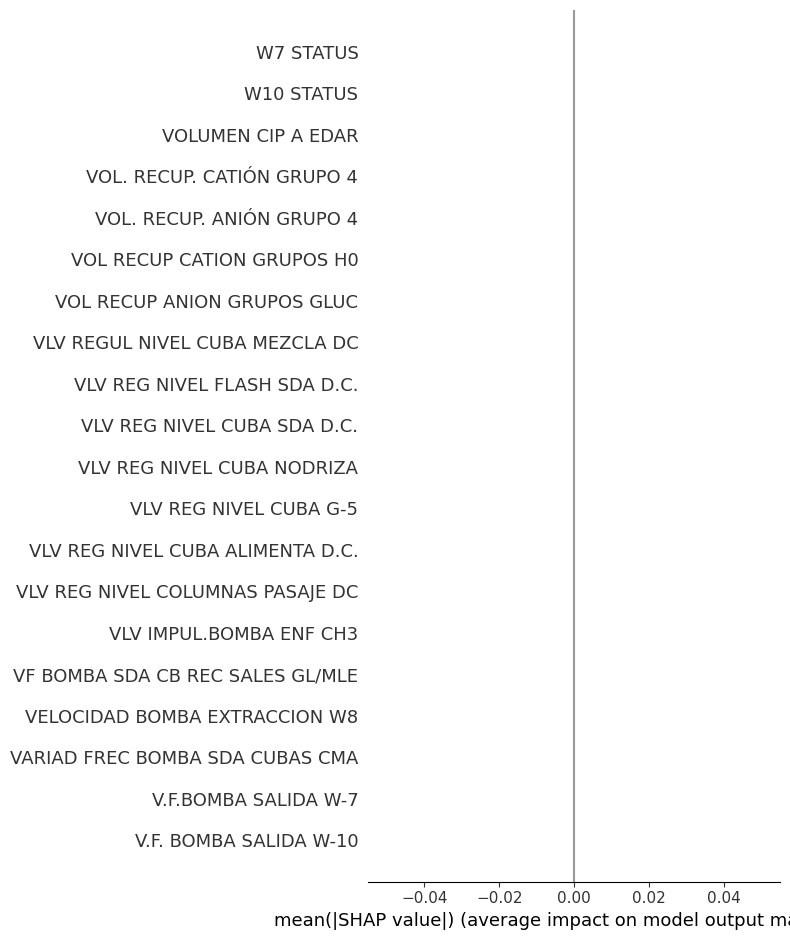

In [45]:
plt.figure()
shap.summary_plot(shap_values, X, plot_type="bar")
plt.show()

c:\Users\Pacotm\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\plots\_decision.py:78: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(xlim)


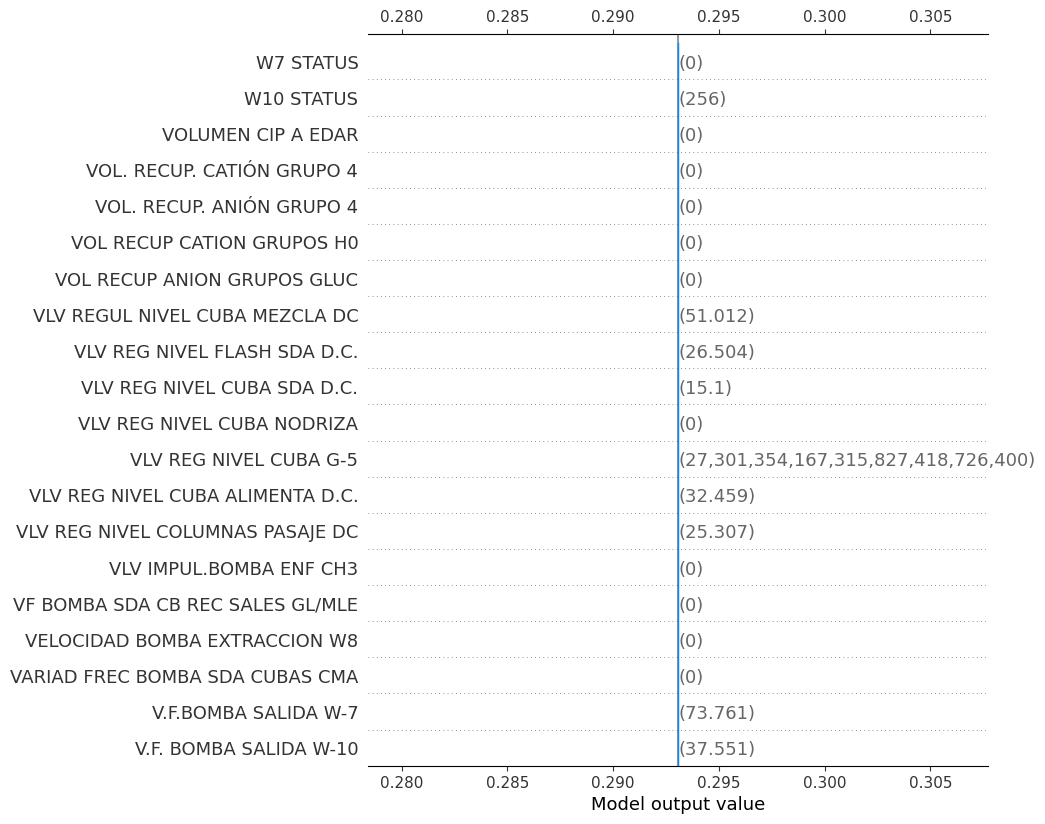

In [46]:
plt.figure()
shap.decision_plot(explainer.expected_value, shap_values[0], X.iloc[0])
plt.show()

In [47]:
# feature_importances = np.abs(loaded_model.coef_[0])
# features = X.columns
# importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

In [48]:
# importance_df = importance_df.sort_values(by='Importance', ascending=False)
# print("Feature Importances:")
# print(importance_df)